### ℹ️ **Info**
* **forked original great work kernels**
    * https://www.kaggle.com/code/abdmental01/cmi-single-lgbm
    
* **2024/09/26 My Changed**
    * add more "stat" fe※
    * FeatureSelection & ReTrain

```
※"stat_"FE
The columns with the 'stat_' prefix represent numerical features (statistics) that were extracted from each actigraphy dataset file. 
The process_file function likely computes various statistical measures (such as mean, median, standard deviation, min, max, etc.) for each column in the original time-series data. 

see:https://www.kaggle.com/code/abdmental01/cmi-single-lgbm/comments#2997965
```

# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:150%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Child Mind Institute | SIngleLGBM</p>

In [1]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:120%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Basic Preprocess</p>

In [2]:
%%time

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
       'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday','sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season','CGAS-Season','Physical-Season','Fitness_Endurance-Season','FGC-Season',
 'BIA-Season','PAQ_A-Season','PAQ_C-Season','SDS-Season','PreInt_EduHx-Season']

def update(df):
    
    global cat_c
    for c in cat_c : 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
        
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:

    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

CPU times: user 3min 54s, sys: 27.7 s, total: 4min 22s
Wall time: 1min 39s


---
### **》》》Add FE**
---

In [3]:
# fe index check
for i in train.columns.to_list():
    if i.startswith('stat_'):
        print(f"{train.columns.to_list().index(i)},{i}")

59,stat_0
60,stat_1
61,stat_2
62,stat_3
63,stat_4
64,stat_5
65,stat_6
66,stat_7
67,stat_8
68,stat_9
69,stat_10
70,stat_11
71,stat_12
72,stat_13
73,stat_14
74,stat_15
75,stat_16
76,stat_17
77,stat_18
78,stat_19
79,stat_20
80,stat_21
81,stat_22
82,stat_23
83,stat_24
84,stat_25
85,stat_26
86,stat_27
87,stat_28
88,stat_29
89,stat_30
90,stat_31
91,stat_32
92,stat_33
93,stat_34
94,stat_35
95,stat_36
96,stat_37
97,stat_38
98,stat_39
99,stat_40
100,stat_41
101,stat_42
102,stat_43
103,stat_44
104,stat_45
105,stat_46
106,stat_47
107,stat_48
108,stat_49
109,stat_50
110,stat_51
111,stat_52
112,stat_53
113,stat_54
114,stat_55
115,stat_56
116,stat_57
117,stat_58
118,stat_59
119,stat_60
120,stat_61
121,stat_62
122,stat_63
123,stat_64
124,stat_65
125,stat_66
126,stat_67
127,stat_68
128,stat_69
129,stat_70
130,stat_71
131,stat_72
132,stat_73
133,stat_74
134,stat_75
135,stat_76
136,stat_77
137,stat_78
138,stat_79
139,stat_80
140,stat_81
141,stat_82
142,stat_83
143,stat_84
144,stat_85
145,stat_86
146,sta

In [4]:
"""
59,stat_0
154,stat_95
"""
for i in range(59,154,5):
    train[f"stat_mean{i}"] = train.iloc[:, i:i+5].mean(axis=1)
#     train[f"stat_sum{i}"] = train.iloc[:, i:i+5].sum(axis=1)

train[f"stat_mean_all"] = train.iloc[:, 59:154].mean(axis=1)
# train[f"stat_sum_all"] = train.iloc[:, 59:154].sum(axis=1)

# ---------------------------------------------------------------- #
for i in range(58,153,5):
    test[f"stat_mean{i+1}"] = test.iloc[:, i:i+5].mean(axis=1)
#     test[f"stat_sum{i+1}"] = test.iloc[:, i:i+5].sum(axis=1)

test[f"stat_mean_all"] = test.iloc[:, 58:153].mean(axis=1)
# test[f"stat_sum_all"] = test.iloc[:, 58:153].sum(axis=1)

In [5]:
%%time

train.head()

CPU times: user 304 µs, sys: 37 µs, total: 341 µs
Wall time: 355 µs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,stat_mean59,stat_mean64,stat_mean69,stat_mean74,stat_mean79,stat_mean84,stat_mean89,stat_mean94,stat_mean99,stat_mean104,stat_mean109,stat_mean114,stat_mean119,stat_mean124,stat_mean129,stat_mean134,stat_mean139,stat_mean144,stat_mean149,stat_mean_all
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [6]:
%%time

test.head()

CPU times: user 232 µs, sys: 27 µs, total: 259 µs
Wall time: 259 µs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,stat_mean59,stat_mean64,stat_mean69,stat_mean74,stat_mean79,stat_mean84,stat_mean89,stat_mean94,stat_mean99,stat_mean104,stat_mean109,stat_mean114,stat_mean119,stat_mean124,stat_mean129,stat_mean134,stat_mean139,stat_mean144,stat_mean149,stat_mean_all
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:120%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Modeling | Single LGBM</p>

In [7]:
%%time

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    models = []
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)
        models.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, models, X

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.6 µs


In [8]:
%%time

Params = {'learning_rate': 0.04603534510792164, 'max_depth': 12, 'num_leaves': 478, 'min_data_in_leaf': 13,
          'feature_fraction': 0.8935304204489449, 'bagging_fraction': 0.7840117449237969, 'bagging_freq': 4,
          'lambda_l1': 6.596560434072009, 'lambda_l2': 2.680080551210706e-06} 

Light = lgb.LGBMRegressor(**Params,random_state=SEED, verbose=-1,n_estimators=200)
Submission, models_train1, X = TrainML(Light,test)

Training Folds: 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]

Mean Train QWK --> 0.8139
Mean Validation QWK ---> 0.3927


----> || Optimized QWK SCORE ::  0.444
CPU times: user 20.4 s, sys: 680 ms, total: 21.1 s
Wall time: 19.4 s


---
### **》》》Importance&FeatureSelection**
---

Text(0.5, 1.0, 'Feature Importance')

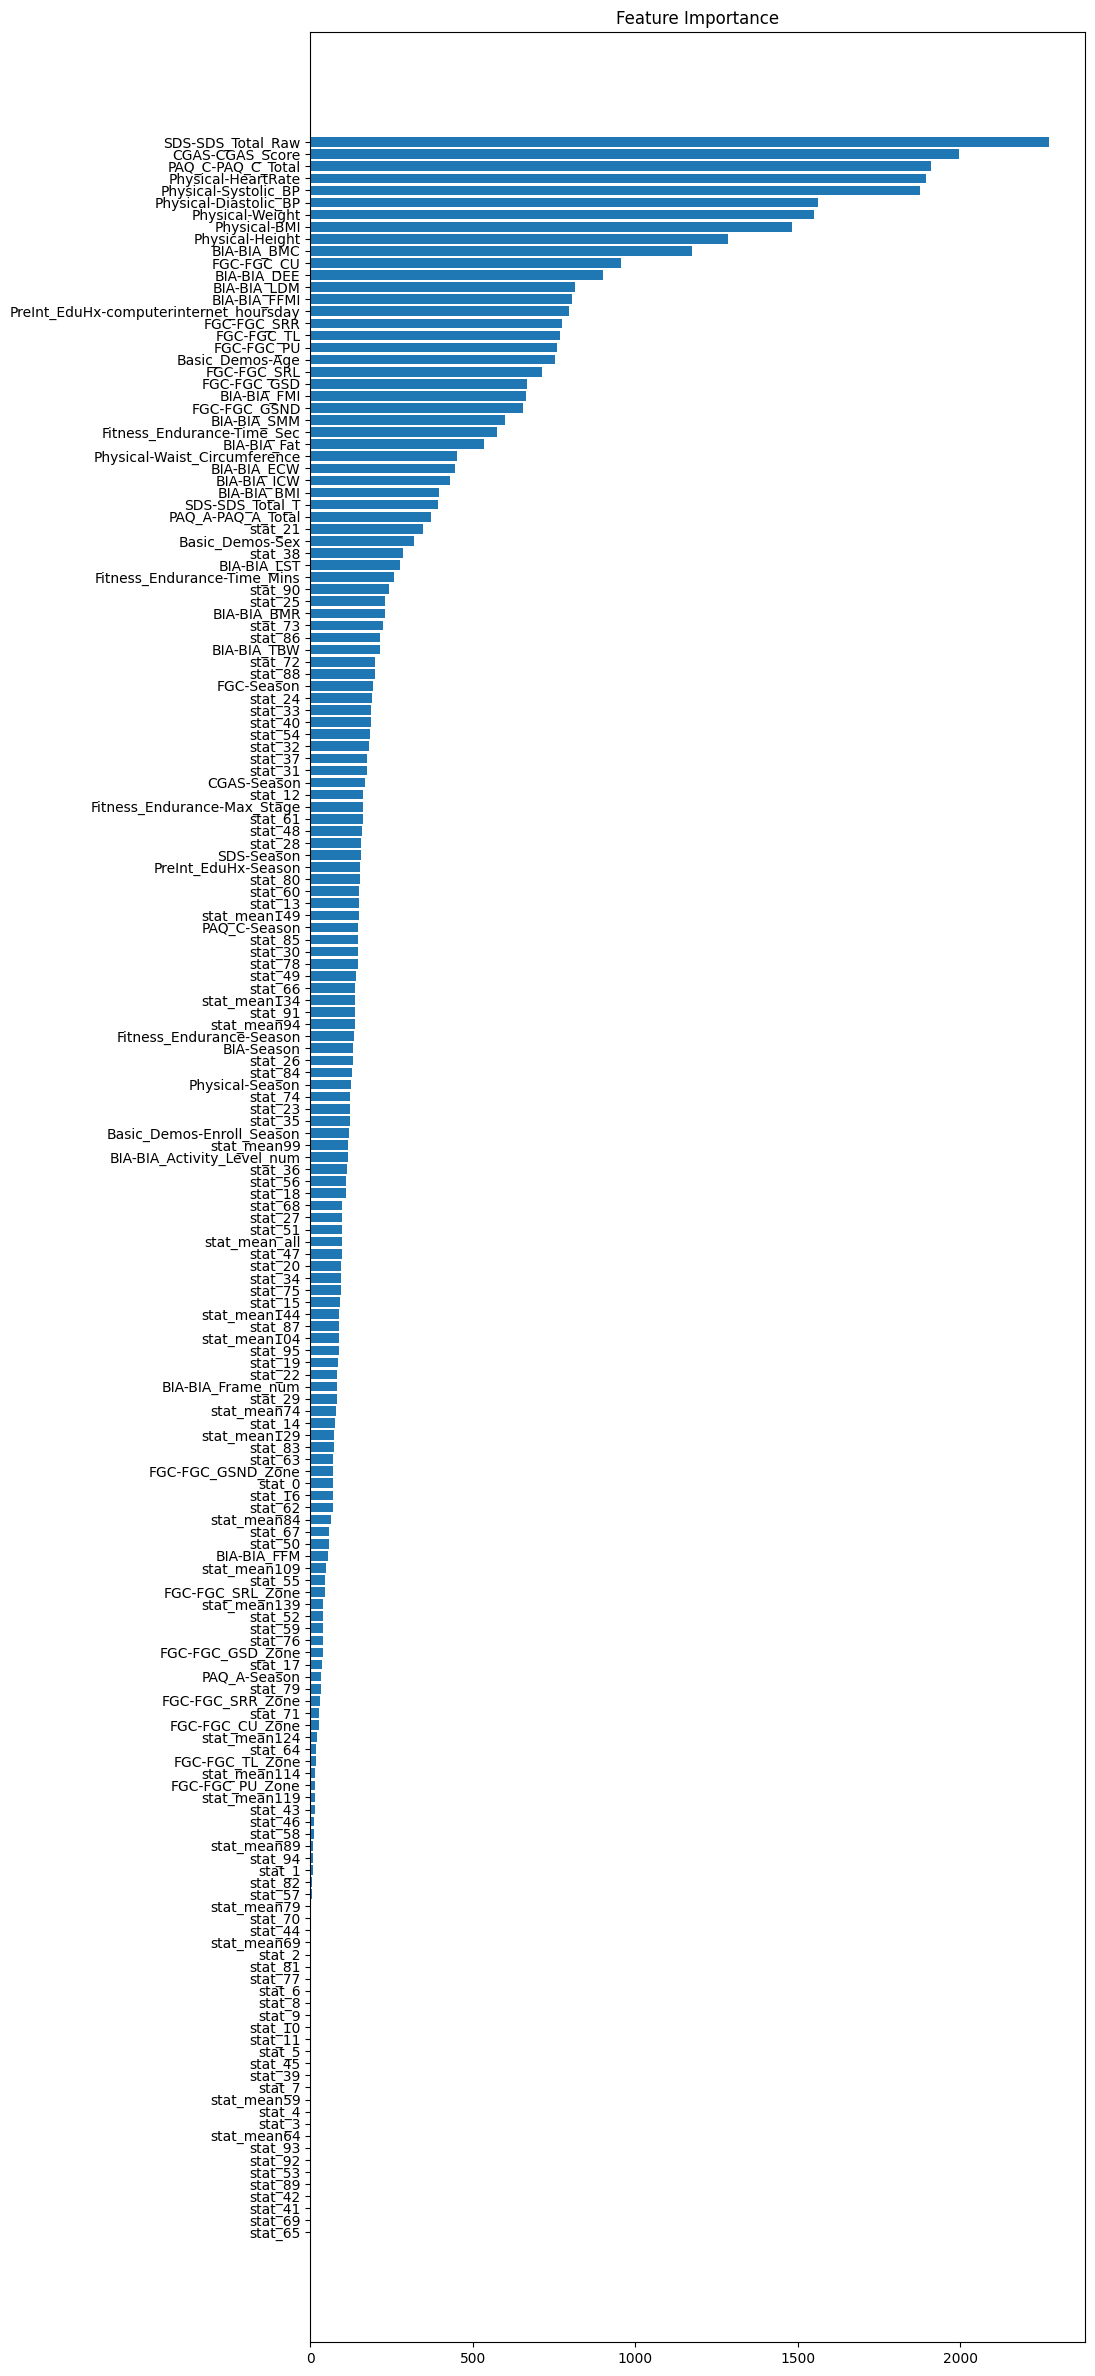

In [9]:
import matplotlib.pyplot as plt
importance_df = pd.DataFrame(np.sum([model.feature_importances_ for model in models_train1], axis=0), index=X.columns, columns=['importance']).sort_values('importance',ascending=True)
importance_df

fig = plt.figure(figsize=(10, 30))
plt.barh(importance_df.index, importance_df["importance"], align="center")
plt.title("Feature Importance")

In [10]:
IMPOTTANCE_TH = 0
drop_fes = importance_df[importance_df["importance"]<=IMPOTTANCE_TH].index.to_list()
drop_fes

['stat_65',
 'stat_69',
 'stat_41',
 'stat_42',
 'stat_89',
 'stat_53',
 'stat_92',
 'stat_93',
 'stat_mean64',
 'stat_3',
 'stat_4',
 'stat_mean59',
 'stat_7',
 'stat_39',
 'stat_45',
 'stat_5',
 'stat_11',
 'stat_10',
 'stat_9',
 'stat_8',
 'stat_6']

In [11]:
train = train.drop(columns=drop_fes)
test = test.drop(columns=drop_fes)

---
### **》》》ReTrain**
---

In [12]:
%%time

Params = {'learning_rate': 0.04603534510792164, 'max_depth': 12, 'num_leaves': 478, 'min_data_in_leaf': 13,
          'feature_fraction': 0.8935304204489449, 'bagging_fraction': 0.7840117449237969, 'bagging_freq': 4,
          'lambda_l1': 6.596560434072009, 'lambda_l2': 2.680080551210706e-06} 

Light = lgb.LGBMRegressor(**Params,random_state=SEED, verbose=-1,n_estimators=200)
Submission, models_train1, X = TrainML(Light,test)

Training Folds: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

Mean Train QWK --> 0.8181
Mean Validation QWK ---> 0.4009


----> || Optimized QWK SCORE ::  0.443
CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 17.1 s


Text(0.5, 1.0, 'Feature Importance')

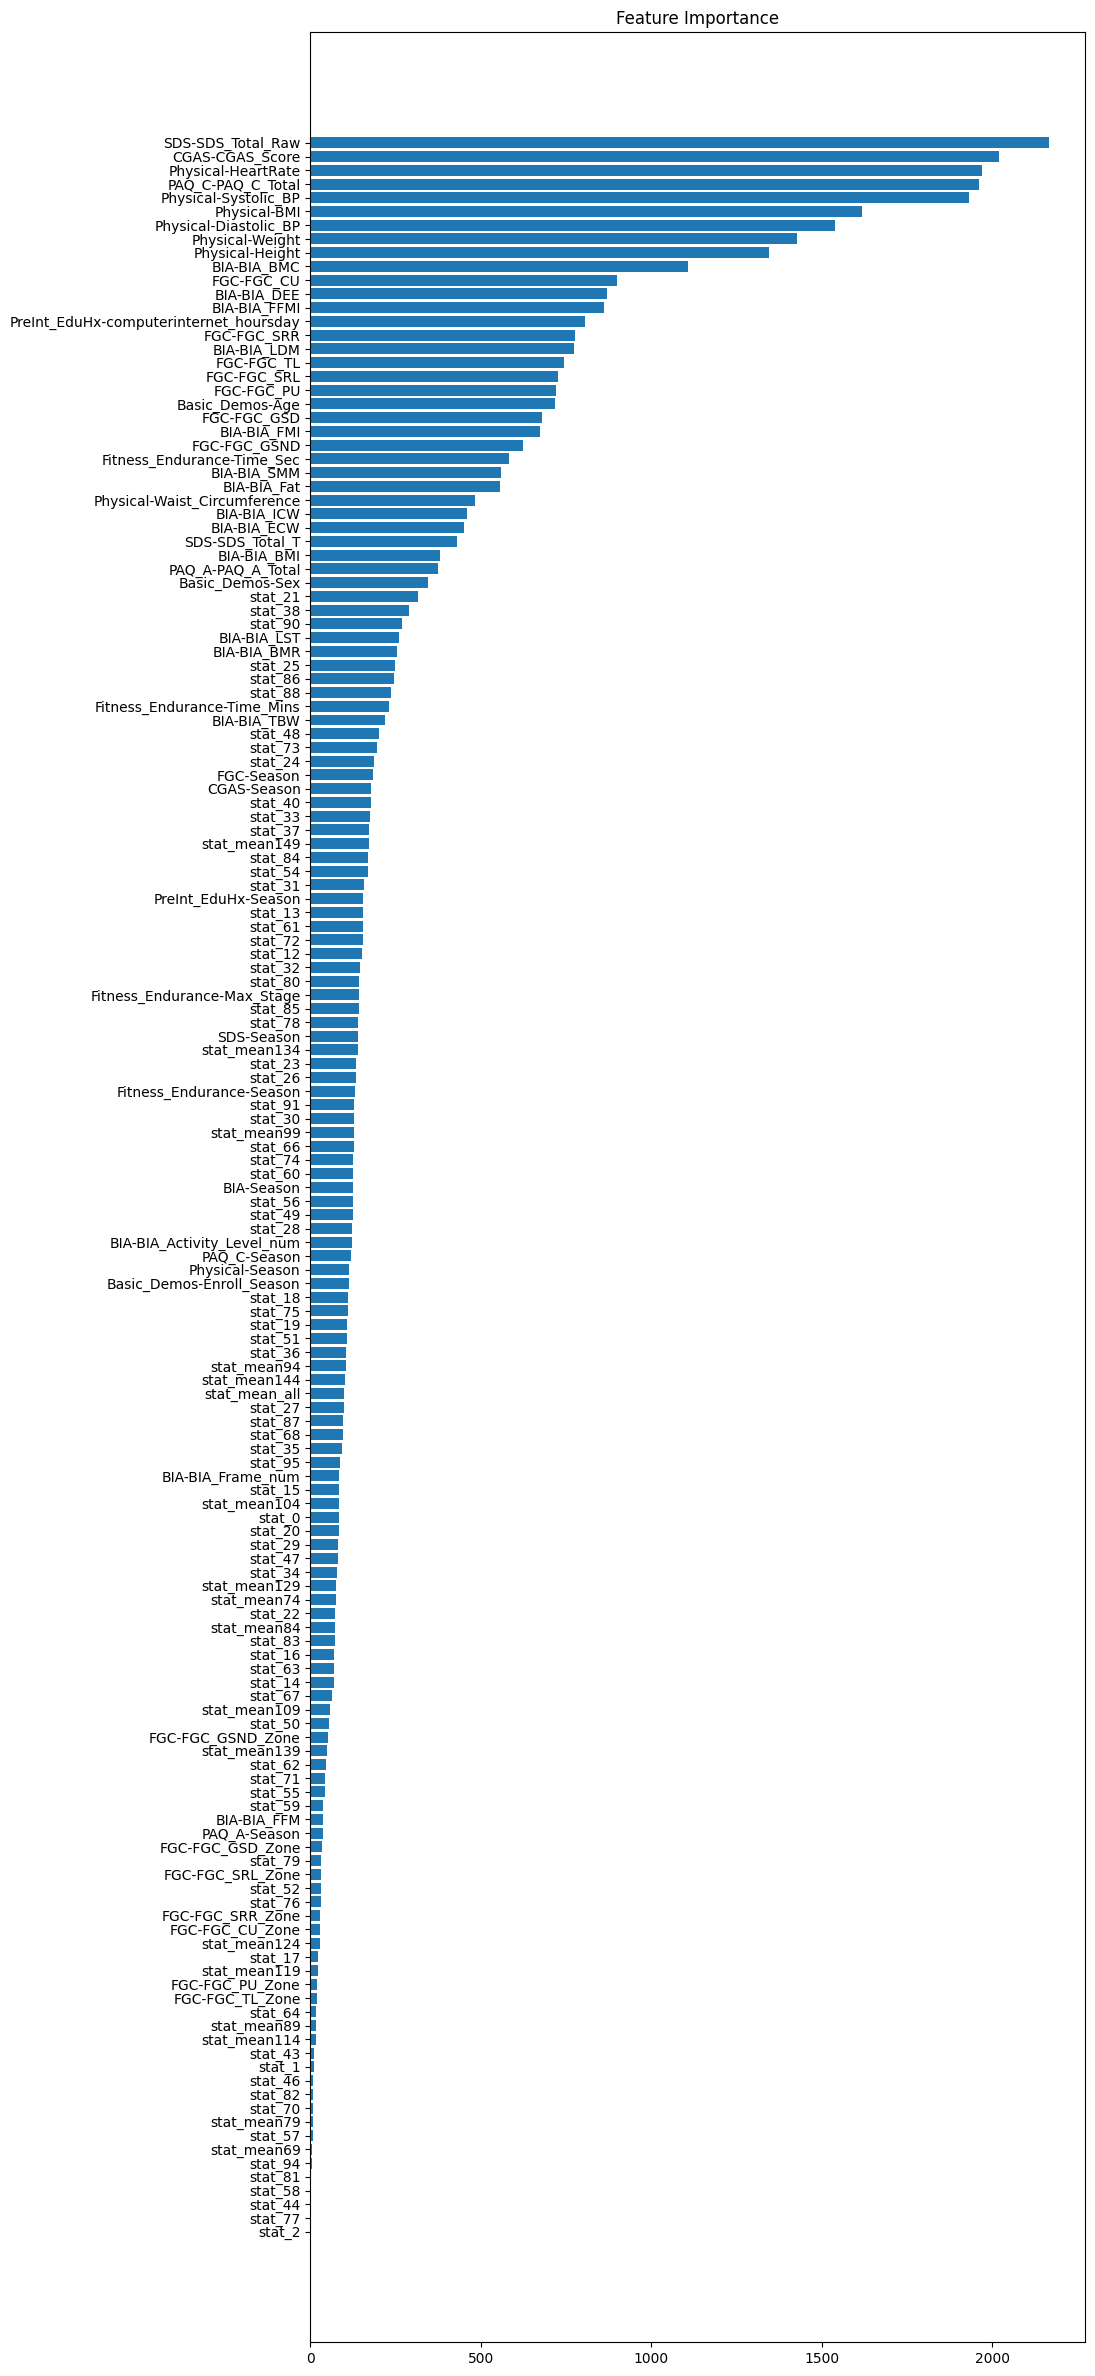

In [13]:
import matplotlib.pyplot as plt
importance_df = pd.DataFrame(np.sum([model.feature_importances_ for model in models_train1], axis=0), index=X.columns, columns=['importance']).sort_values('importance',ascending=True)
importance_df

fig = plt.figure(figsize=(10, 30))
plt.barh(importance_df.index, importance_df["importance"], align="center")
plt.title("Feature Importance")

# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:120%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Submission</p>

In [14]:
%%time

Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
0    12
1     6
2     2
Name: count, dtype: int64
CPU times: user 4.44 ms, sys: 39 µs, total: 4.48 ms
Wall time: 6 ms
